In [109]:
import pickle
import torch
import torchtext.transforms as T
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

def loadFiles(file):
    with open(file, "rb") as file:
        data = pickle.load(file)
    print("The size of the dataset is:", len(data))
    return data


def separateData(data):
    X = data[:, 0]
    y = data[:, 1]
    return X, y

In [110]:
data = loadFiles(r'./english-german-both.pkl')

The size of the dataset is: 10000


In [111]:
eng, germ = separateData(data)

In [112]:
def findLongestSequence(sentList):
    return max(len(seq.split()) for seq in sentList)


In [113]:
enTokenizer = get_tokenizer('basic_english')
deTokenizer = get_tokenizer('basic_english')
def yieldTokensEn(data):
    for text in data:
        yield enTokenizer(text[:-1])

def yieldTokensDe(data):
    
    for text in data:
        yield deTokenizer(text[:-1])

In [114]:
vocabEn = build_vocab_from_iterator(yieldTokensEn(eng), specials=["<pad>", "<sos>", "<eos>", "<unk>"], special_first=True)
vocabDe = build_vocab_from_iterator(yieldTokensDe(germ), specials=["<pad>", "<sos>", "<eos>", "<unk>"], special_first=True)

In [115]:
textPipelineEn = lambda x: vocabEn(enTokenizer(x))
textPipelineDe = lambda x: vocabDe(deTokenizer(x))

In [116]:
from sklearn.model_selection import train_test_split

SEED = 42
trainEn, testEn, trainDe, testDe = train_test_split(eng, germ, test_size=0.1, random_state=SEED)
# trainEn, valEn, trainDe, valDe = train_test_split(eng, germ, test_size=0.1, random_state=SEED)

In [117]:
BATCH_SIZE = 32
PAD_IDX = vocabEn(['<pad>'])[0]
SOS_IDX = vocabEn(['<sos>'])
EOS_IDX = vocabEn(['<eos>'])
print(PAD_IDX)
print(SOS_IDX)
print(EOS_IDX)

0
[1]
[2]


In [118]:
from torch.nn.utils.rnn import pad_sequence

def generateData(eng, deu):
    data = []
    for en, de in zip(eng, deu):
        enTensor = torch.tensor(textPipelineEn(en[:-1]), dtype=torch.long)
        deTensor = torch.tensor(textPipelineDe(de[:-1]), dtype=torch.long)
        data.append((enTensor, deTensor))
    return data


trainData = generateData(trainEn, trainDe)
# valData = generateData(valEn, valDe)         
testData = generateData(testEn, testDe)        

In [119]:
from torch.utils.data import DataLoader

    
def generateBatch(data_batch):
  de_batch, en_batch = [], []
  # print(data_batch)
  for (de_item, en_item) in data_batch:
    de_batch.append(torch.cat([torch.tensor(SOS_IDX), de_item, torch.tensor(EOS_IDX)], dim=0))
    en_batch.append(torch.cat([torch.tensor(SOS_IDX), en_item, torch.tensor(EOS_IDX)], dim=0))
  deLength = len(de_batch)
  batch = pad_sequence(en_batch + de_batch, padding_value=PAD_IDX, batch_first=True)
  en_batch, de_batch = batch[:deLength], batch[deLength:]
  return de_batch, en_batch


trainIter = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generateBatch)
# valIter =  DataLoader(valData, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generateBatch)
testIter = DataLoader(testData, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generateBatch)


In [120]:
from model.transformer import Transformer
from model.positenc import PositionalEncodingTorch
from torch.nn import Embedding, Module, Linear, Dropout

EMB_DIM = 128
HEADS = 32
LINEAR_DIM = 512
DROPOUT = 0.3
LAYERS = 2
BETA_1 = 0.9
BETA_2 = 0.98
EPSILON = 10**-7
ENG_VOCAB_LEN = vocabEn.__len__()
DE_VOCAB_LEN = vocabDe.__len__()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"The english has {ENG_VOCAB_LEN} words.")
print(f"The german has {DE_VOCAB_LEN} words.")

EN_MAX_SEQ_LEN, DE_MAX_SEQ_LEN = findLongestSequence(eng) + 2 , findLongestSequence(germ) + 2

#mask for the decoder
def createMask(x):
    batch, seq_length, _ = x.size()
    mask = torch.ones((batch, seq_length, seq_length)).to(device)
    mask = torch.tril(mask, diagonal=0)
    return mask

def createMaskGen(x):
    x = x.unsqueeze(1)
    batch, _, seq_length = x.size()
    mask = torch.ones((batch, 1, seq_length)).to(device)
    maskR = torch.logical_and(mask, x)
    maskC = torch.logical_and(x.transpose(-1, 1), mask.transpose(-1, 1))
    mask = torch.multiply(maskR, maskC)
    return mask
    


class TransformerModel(Module):
    def __init__(self):
        super().__init__()
        self.embEn = Embedding(ENG_VOCAB_LEN, EMB_DIM)
        self.embDe = Embedding(DE_VOCAB_LEN, EMB_DIM)
        self.positEn = PositionalEncodingTorch(EN_MAX_SEQ_LEN, EMB_DIM)
        self.positDe = PositionalEncodingTorch(DE_MAX_SEQ_LEN, EMB_DIM)
        self.transformer = Transformer(LAYERS, EMB_DIM, EMB_DIM, HEADS, LINEAR_DIM, DROPOUT)
        self.linear = Linear(EMB_DIM, DE_VOCAB_LEN)
        self.dropout = Dropout(0.2)
        
    def forward(self, eng, de, device=device, ret_att=False):
        mask1 = createMaskGen(eng)
        eng = self.embEn(eng)
        eng = self.positEn(eng, device=device)
        eng = self.dropout(eng)
        mask = createMaskGen(de)
        de = self.embDe(de)
        de = self.positDe(de, device=device)
        de = self.dropout(de)
        mask2 = createMask(de)
        mask2 = torch.logical_and(mask, mask2)
        softmax, dec = self.transformer(eng, de, mask1, mask2, return_att=ret_att)
        lin = self.linear(dec) 
        if ret_att:
            return softmax, lin   
        return lin
        






The english has 2630 words.
The german has 4167 words.


In [121]:
class TransformerLRScheduler(object):
    def __init__(self,  warmup_steps:int=10, d_model:int=512):
        self.warmup_steps = warmup_steps
        self.d_model = d_model
    
    
    def __call__(self, epoch):
        epoch = epoch + 1
        minimum = min(epoch**-0.5, epoch * ((self.warmup_steps) ** (-1.5)))
        return (self.d_model**-0.5 ) * minimum
    

In [122]:
def calculateAccuracy(prediction, target):
    padding_mask = torch.logical_not(torch.eq(target, torch.tensor(0)))
    accuracy = torch.eq(target, torch.argmax(prediction, axis=2))
    accuracy = torch.logical_and(padding_mask, accuracy)
    accuracy = accuracy.type(torch.float32)
    padding_mask = padding_mask.type(torch.float32)
    return torch.sum(accuracy) / torch.sum(padding_mask)
    

In [123]:
def validateModel(model, testIter, loss, device):
    lossPerBatch = []
    accPerBatch = []
    with torch.no_grad():
        model.eval()
        for i, (X, y) in enumerate(testIter):
            X, y = X.to(device), y.to(device)
            out = model(X[:, 1:], y[:, :-1])
            l = loss(out.contiguous().view(-1, 4167), y[:, 1:].contiguous().view(-1))
            a = calculateAccuracy(out, y[:, 1:])
            lossPerBatch.append(l.item())
            accPerBatch.append(a.item())
        meanLoss = sum(lossPerBatch)/len(lossPerBatch)
    return lossPerBatch, meanLoss, accPerBatch

In [124]:
from torch import optim
import torch.nn as nn
from torch.optim import lr_scheduler
model = TransformerModel()
model.to(device)
optimizer = optim.Adam(model.parameters(), betas=(BETA_1, BETA_2), eps=EPSILON)
loss = nn.CrossEntropyLoss(ignore_index=0)
scheduler = TransformerLRScheduler(20)

In [255]:
from tqdm import tqdm

def train(model, trainIter, 
          testIter=None, 
          epochs=None, 
          loss=None, 
          optimizer=None, 
          device=device, 
          scheduler=None):
    # model.to(device)
    # pbar = trange(epochs, desc="Epochs ", unit="batches")
    # with tqdm(trainIter, unit="epochs") as tepoch:
    logs_dic = {
        "valildationLoss": [],
        "trainingLoss" : [],
        "validationAccuracy": [],
        "trainingAccuracy": []
    }
    for epoch in range(epochs):
        trainLossPerBatch = []
        trainAccuracyPerBatch = []
        with tqdm(trainIter, unit="batches") as tepoch:
            for i, (X,y) in enumerate(tepoch):
                model.train()
                optimizer.zero_grad()
                
                X, y = X.to(device), y.to(device)
                out = model(X[:, 1:], y[:, :-1])
                l = loss(out.contiguous().view(-1, 4167), y[:, 1:].contiguous().view(-1))
                # print(out.contiguous().view(-1, 4167).detach().numpy().argmax(axis=1))
                # print(y[:, 1:].contiguous().view(-1))
                acc = calculateAccuracy(out, y[:, 1:])
                trainLossPerBatch.append(l.item())
                trainAccuracyPerBatch.append(acc.item())
                tepoch.set_description(f"Epoch {epoch + 1}")            
                tepoch.set_postfix(loss=l.item(), accuracy=acc.item())
                l.backward()
                optimizer.step()
                # break
            
            valLoss, meanValLoss, valAcc = validateModel(model, testIter, loss=loss, device=device)
            print(f"The validation loss is: {meanValLoss}")
            logs_dic["valildationLoss"].append(valLoss)
            logs_dic["trainingLoss"].append(trainLossPerBatch)
            logs_dic["trainingAccuracy"].append(trainAccuracyPerBatch)
            logs_dic["validationAccuracy"].append(valAcc)
            # break
            # print(f"Epoch: {epoch+1}     loss: {l}")
            if scheduler:
                if scheduler.__module__ == lr_scheduler.__name__:
                    scheduler.step()
                else:
                    for param_group in optimizer.param_groups:
                        lr = scheduler(epoch)
                        param_group['lr'] = lr
    return logs_dic
trainIter = DataLoader(trainData, batch_size=64, shuffle=True, collate_fn=generateBatch)

history = train(model, trainIter, testIter=testIter, epochs=10, loss=loss, optimizer=optimizer, device=device, scheduler=scheduler)

Epoch 1: 100%|██████████| 141/141 [00:10<00:00, 13.86batches/s, accuracy=0.995, loss=0.0132]


The validation loss is: 6.23161374573066


Epoch 2: 100%|██████████| 141/141 [00:10<00:00, 14.04batches/s, accuracy=0.989, loss=0.0566] 


The validation loss is: 5.872516851436185


Epoch 3: 100%|██████████| 141/141 [00:10<00:00, 13.98batches/s, accuracy=1, loss=0.0023]     


The validation loss is: 5.8816502362849015


Epoch 4: 100%|██████████| 141/141 [00:10<00:00, 13.88batches/s, accuracy=1, loss=0.00241]    


The validation loss is: 5.961338259111193


Epoch 5: 100%|██████████| 141/141 [00:09<00:00, 14.30batches/s, accuracy=1, loss=0.00433]    


The validation loss is: 6.356656257134709


Epoch 6: 100%|██████████| 141/141 [00:09<00:00, 14.37batches/s, accuracy=0.994, loss=0.016]  


The validation loss is: 6.083515707189392


Epoch 7: 100%|██████████| 141/141 [00:10<00:00, 13.91batches/s, accuracy=0.978, loss=0.0737]


The validation loss is: 6.336440627593193


Epoch 8: 100%|██████████| 141/141 [00:10<00:00, 13.94batches/s, accuracy=0.977, loss=0.105] 


The validation loss is: 6.7412312291678145


Epoch 9: 100%|██████████| 141/141 [00:10<00:00, 14.10batches/s, accuracy=0.974, loss=0.107] 


The validation loss is: 6.405972136538141


Epoch 10: 100%|██████████| 141/141 [00:10<00:00, 13.60batches/s, accuracy=0.959, loss=0.113] 


The validation loss is: 6.737537273824875


In [126]:
def saveHistory(history, filename):
    print("pickling history.")
    with open(filename, 'wb') as fp:
        pickle.dump(history, fp)
    print("successfully pickled") 
    
# saveHistory(history, "./history5")   

In [127]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# lr = TransformerLRScheduler(1000)
# plt.plot([i for i in range(5000)], [lr(i) for i in range(5000)])
# plt.grid()
# plt.xlabel('Epochs')
# plt.ylabel("Learning Rate")

In [128]:
# torch.save(model.state_dict(), '3.pth')


In [309]:

def calculateAccuracyTest(prediction, target):
    targLen = len(target[0, :])
    paddingMask = torch.logical_not(torch.eq(target, torch.tensor(0)))
    paddingMask = torch.logical_not(torch.eq(target, torch.tensor(1))) & paddingMask
    paddingMask = torch.logical_not(torch.eq(target, torch.tensor(2))) & paddingMask
    accuracy = torch.eq(target[:, :],prediction[:, :targLen])
    accuracy = torch.logical_and(paddingMask, accuracy)
    accuracy = accuracy.type(torch.float32)
    paddingMask = paddingMask.type(torch.float32)
    return torch.sum(accuracy) / torch.sum(paddingMask)

def test(model, encInput):
    model.eval()
    batch, seq_length = encInput.size()
    out = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    decOutput =  torch.tensor(out)
    decOutput = torch.tile(decOutput, (batch, 1))
    for i in range(DE_MAX_SEQ_LEN-1):
        softmax, prediction = model(encInput.to(device)[:, :], decOutput.to(device), ret_att=True)
        # print(prediction.shape)
        prediction = prediction[:, i, :]
        predictedId = torch.argmax(prediction, dim=-1)
        decOutput[:, i+1] = predictedId[ :]
        if predictedId.tolist()[0] == EOS_IDX[0]:
          break
    return softmax, decOutput
testIter = DataLoader(testData, batch_size=1, shuffle=True, collate_fn=generateBatch)
trainIter = DataLoader(trainData, batch_size=1, shuffle=True, collate_fn=generateBatch)

for i, (X, Y) in enumerate(trainIter):
    softmax, pred = test(model, X)
    meanSM = torch.mean(softmax, dim=1)
    for x, y, z in zip(pred.tolist(), X.tolist(), Y.tolist()):
      print(' '.join(vocabDe.lookup_tokens(x)))
      print(' '.join(vocabEn.lookup_tokens(y)))
      print(' '.join(vocabDe.lookup_tokens(z)))
      print("The accuracy for this prediction is:", round(calculateAccuracyTest(pred, Y).item(), 4))
      print("\n")
      
    if i == 1:
      break

<sos> kommt nicht komm komm komm <eos> <pad> <pad> <pad> <pad> <pad>
<sos> return fir <eos> <pad>
<sos> schieen sie zuruc <eos>
The accuracy for this prediction is: 0.0


<sos> nimm mich mein ein idio <eos> <pad> <pad> <pad> <pad> <pad>
<sos> she isnt pick <eos> <pad>
<sos> sie ist nicht pingeli <eos>
The accuracy for this prediction is: 0.0




<sos> sign thi <eos>
Pred is: <sos> unterschreib da <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Targ is: <sos> unterschreib da <eos>
The accuracy for this prediction is: 1.0




[Text(0, 0.5, '<sos>'),
 Text(0, 1.5, 'sign'),
 Text(0, 2.5, 'this'),
 Text(0, 3.5, '<eos>')]

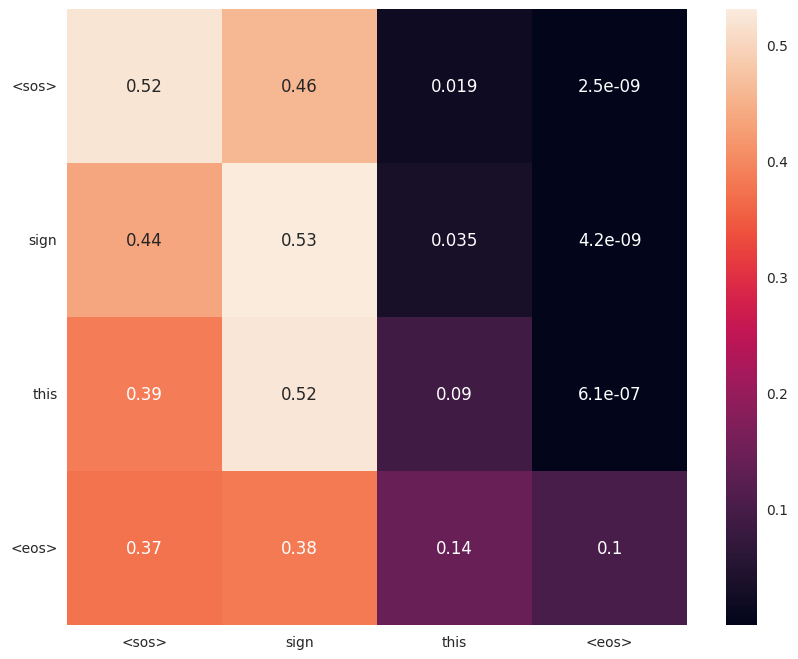

In [315]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

model.load_state_dict(torch.load('6.pth', map_location='cpu'))


def generateSmMatrix(enText, deText):
    enText = np.array(enText).reshape(-1)
    deText = np.array(deText).reshape(-1)
    # print(enText)
    data = generateData(enText, deText)
    enTensor, deTensor = generateBatch(data)
    # print(enTensor, deTensor)
    softmax, pred = test(model, enTensor)
    # meanSM = softmax
    meanSM = torch.mean(softmax, dim=1)
    for x, y, z in zip(pred.tolist(), enTensor.tolist(), deTensor.tolist()):
      print(' '.join(vocabEn.lookup_tokens(y)))
      print('Pred is: ' + ' '.join(vocabDe.lookup_tokens(x)))
      print('Targ is: '+' '.join(vocabDe.lookup_tokens(z)))
      print("The accuracy for this prediction is:", round(calculateAccuracyTest(pred, deTensor).item(), 4))
      print("\n")
    return meanSM
# index = 423
# meanSM = generateSmMatrix(enText=trainEn[index], deText=trainDe[index])
# meanSM = generateSmMatrix(enText=trainEn[12], deText=trainDe[12])

meanSM = generateSmMatrix(enText="sign this", deText="unterschreib das")

# print(meanSM.shape)
meanSM = meanSM.squeeze(0)
meanSM = meanSM.squeeze(0)
meanSM = meanSM.squeeze(1)

# print(meanSM)
plt.figure(figsize=(10, 8))
hm = sn.heatmap(meanSM.detach().numpy(), annot=True, annot_kws={"size": 12}, xticklabels="<sos> sign this <eos>".split() )
hm.set_yticklabels("<sos> sign this <eos>".split(), rotation=0)

In [131]:

def showHistory(pickleFile, emb, layers, epochs=100, maTicks=10, miTicks=5):

    with open(pickleFile, 'rb') as fp:
        logs = pickle.load(fp)


    trainLoss = logs['trainingLoss']
    trainAcc = logs['trainingAccuracy']
    valAcc = logs['validationAccuracy']
    valLoss = logs['valildationLoss']
    def calcAvgPerEpoch(arr):
        lossPerEpoch = []
        for bl in arr:
            mLoss = sum(bl) / len(bl)
            lossPerEpoch.append(mLoss)
        return lossPerEpoch
    trLossPE = calcAvgPerEpoch(trainLoss)
    trAccPE = calcAvgPerEpoch(trainAcc)
    valLossPE = calcAvgPerEpoch(valLoss)
    valAccPE = calcAvgPerEpoch(valAcc)
    plt.style.use('seaborn-v0_8')
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    major_ticks = np.arange(0, epochs + 1, maTicks)
    minor_ticks = np.arange(0, epochs + 1, miTicks)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    major_ticks = np.arange(0, 5, 0.25)
    minor_ticks = np.arange(0, 5, 0.125)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    if epochs >= 99:
        markOn = [2, 5, 10, 20, 50, 60, 80, 99]
    else:
        markOn = range(2, epochs, 2)
    ax.plot(trLossPE, '-*', markevery=markOn, label="Training Loss per Epoch")
    if epochs >= 99:
        markOn = [25, 50, 60, 80, 99]
    ax.plot(valLossPE, '-D', markevery=markOn, label="Validation Loss per Epoch")
    if epochs >= 99:
        markOn = [15, 50, 60, 80, 99]
    ax.plot(trAccPE, '-s', markevery=markOn, label="Training Accuracy per Epoch")
    ax.plot(valAccPE, '-o', markevery=markOn, label="Validation Accuracy per Epoch")
    ax.set_xlabel('Epochs')
    ax.set_title(f"Emb--{emb} Layers--{layers} Trained Transformer ")
    ax.legend()

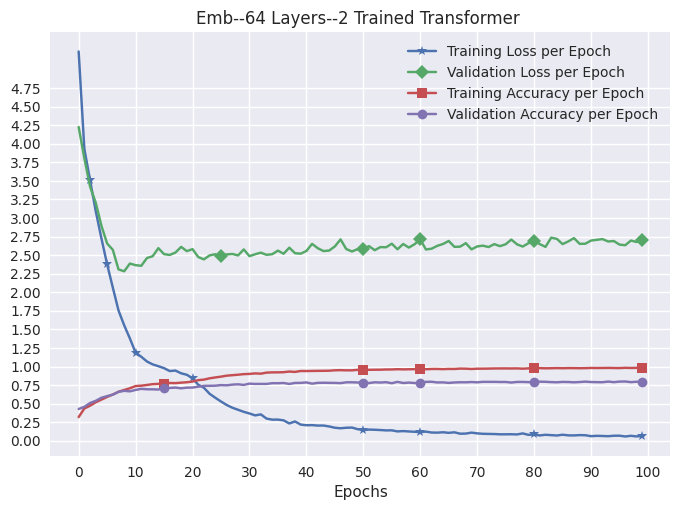

In [132]:
showHistory('history1', 64, 2)

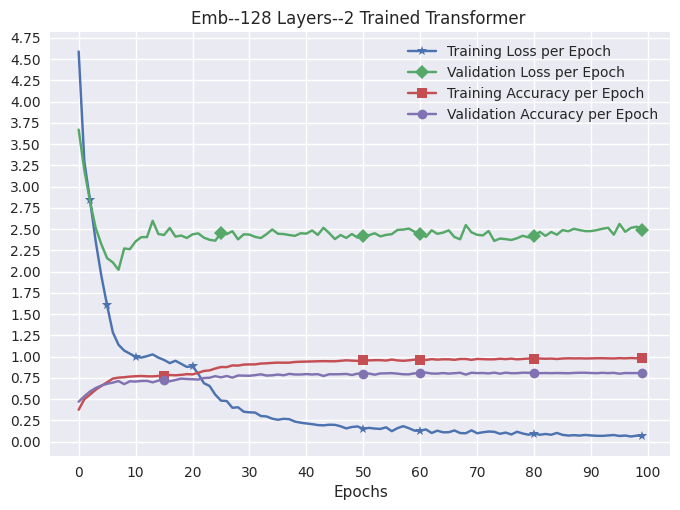

In [133]:

showHistory('history2', 128, 2)




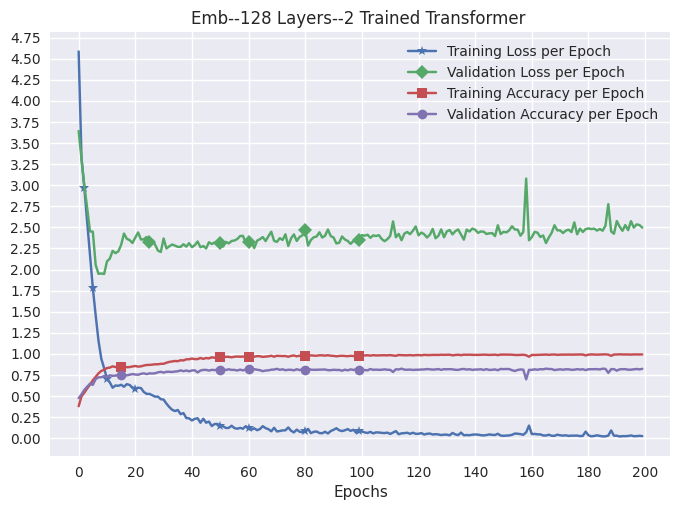

In [134]:
showHistory('history3', 128, 2, 200, maTicks=20, miTicks=10)

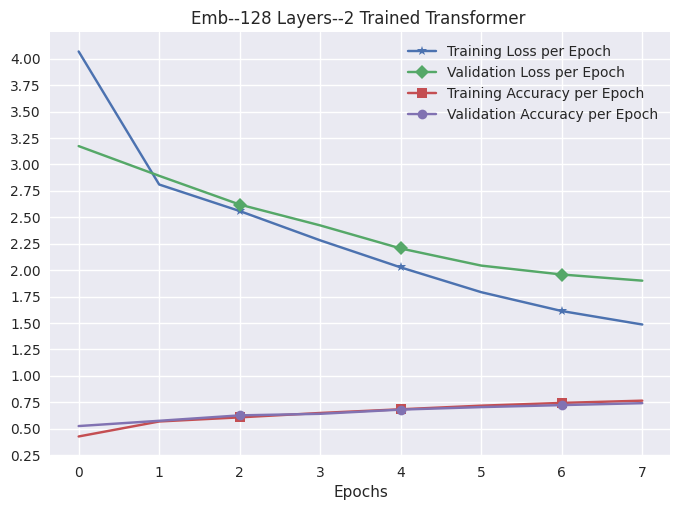

In [230]:
showHistory('history4', 128, 2, 8, 1, 0.5)


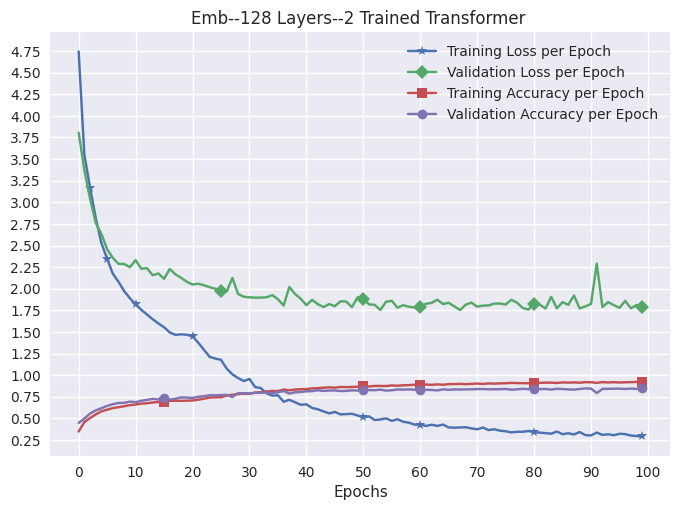

In [231]:
showHistory('history5', 128, 2)



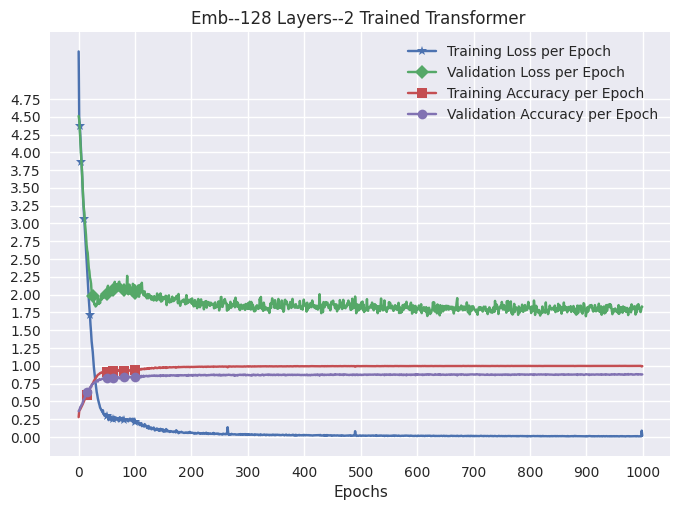

In [232]:
showHistory('history6', 128, 2, 1000, 100, 50)